<a href="https://colab.research.google.com/github/mbolaris/great-white-shark-analysis/blob/main/shark-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook presents an in-depth analysis of white shark movement data, focusing on understanding the relationship between depth and Overall Dynamic Body Acceleration (ODBA) over time. Utilizing a rich dataset, the study aims to decipher patterns in shark behavior and energy expenditure. Through a combination of visualization and analytical techniques, we explore how these magnificent creatures interact with their aquatic environment. Our findings have potential implications for marine biology, conservation efforts, and the broader ecological understanding of shark behaviors in their natural habitat.

## Data Overview

- **Comment**: CEFAS 1 Female 4.5
- **Tag ID**: A14243
- **Firmware**: Version 3, Build Level 70
- **Pressure Range**: 50 units
- **Sensors Count**: 5
- **Deployment Duration**: October 15, 2017, to November 30, 2017

**Mission Parameters**
- **Dive Termination**: 1.5% percentage, 7.5m depth
- **Gravity Range**: 2g
- **Operational Days**: 51

**Data Sampling**
- **Logging Rate**: 1 per minute
- **Resolution**: 12 bits

The dataset contains time-stamped measurements of pressure, temperature, and tri-axial acceleration. These metrics are used to assess the shark's movement behavior.

# Analysis

## Import Libraries

In [1]:
# Install required libraries (if not already installed)
%pip install astral

# Import standard libraries
from datetime import datetime, timedelta
import os
import sys

# Import third-party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pytz import timezone
from astral import LocationInfo
from astral.sun import sun, dawn, dusk

Note: you may need to restart the kernel to use updated packages.


## Data Loading

In [2]:
# Check if the notebook is running on Google Colab
if 'google.colab' in sys.modules:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # Set the base path for data on Google Drive
    base_path = '/content/drive/MyDrive/shark-data/'
else:
    # Set the base path for local data
    base_path = 'C:/shared/shark-data/'

# Define paths to data files
boats_data_path = os.path.join(base_path, 'baby-shark-data-boats.csv')
odba_data_path = os.path.join(base_path, 'baby-shark-data-odba.csv')

# Load datasets
boats_data = pd.read_csv(boats_data_path)
odba_data = pd.read_csv(odba_data_path)

## Data Preparation

In [9]:
# Ensure 'Time Stamp' column is in datetime format
odba_data['Time Stamp'] = pd.to_datetime(odba_data['Time Stamp'])
odba_data['Time Stamp'] = odba_data['Time Stamp'].dt.tz_localize(None)

# Add 'Date' column to odba_data
odba_data['Date'] = odba_data['Time Stamp'].dt.date

# Prepare data for ODBA vs Depth plot
# Define depth intervals (0 to max depth, in 30m increments)
max_depth = odba_data['Pressure (m)'].max()
depth_intervals = np.arange(0, max_depth + 30, 30)
depth_labels = [f"{int(i)}-{int(j)}" for i, j in zip(depth_intervals[:-1], depth_intervals[1:])]

# Categorize 'Pressure (m)' into 'Depth Category'
odba_data['Depth Category'] = pd.cut(odba_data['Pressure (m)'], bins=depth_intervals, labels=depth_labels, include_lowest=True)

# Compute mean and SEM of ODBA grouped by 'Depth Category'
odba_depth = odba_data.groupby('Depth Category', observed=True)['ODBA (g)'].agg(['mean', 'sem'])

## Calculating Day-Night Cycle Times

In [12]:
# Define the location and timezone for sunrise/sunset calculations
# Guadalupe Island Coordinates
latitude = 29.020879
longitude = -118.273103
city = LocationInfo('Guadalupe Island', 'Mexico', 'America/Tijuana', latitude, longitude)
observer = city.observer
local_tz = timezone('America/Tijuana')

# Function to calculate sun cycles for a given date
def calculate_sun_cycles(date):
    sun_times = sun(observer, date=date, tzinfo=local_tz)
    nautical_twilight_start = dawn(observer, date=date, tzinfo=local_tz)
    nautical_twilight_end = dusk(observer, date=date, tzinfo=local_tz)
    return {
        'sunrise': sun_times['sunrise'].replace(tzinfo=None),
        'sunset': sun_times['sunset'].replace(tzinfo=None),
        'nautical_twilight_start': nautical_twilight_start.replace(tzinfo=None),
        'nautical_twilight_end': nautical_twilight_end.replace(tzinfo=None)
    }

# Calculate sun cycles for each date in the data
unique_dates = odba_data['Date'].unique()
sun_cycles = {date: calculate_sun_cycles(date) for date in unique_dates}

# Function to assign 'Time of Day' labels based on sun cycles
def assign_time_of_day(row):
    timestamp = row['Time Stamp']
    date = row['Date']
    cycles = sun_cycles[date]
    if timestamp < cycles['nautical_twilight_start'] or timestamp >= cycles['nautical_twilight_end']:
        return 'Night'
    elif cycles['nautical_twilight_start'] <= timestamp < cycles['sunrise']:
        return 'Dawn'
    elif cycles['sunrise'] <= timestamp < cycles['sunset']:
        return 'Day'
    elif cycles['sunset'] <= timestamp < cycles['nautical_twilight_end']:
        return 'Dusk'
    else:
        return 'Unknown'

# Assign 'Time of Day' to each row in odba_data
odba_data['Time of Day'] = odba_data.apply(assign_time_of_day, axis=1)

# Now that 'Time of Day' column exists, compute mean and SEM
odba_time_of_day = odba_data.groupby('Time of Day')['ODBA (g)'].agg(['mean', 'sem'])

# Reorder the index for plotting
time_of_day_order = ['Night', 'Dawn', 'Day', 'Dusk']
odba_time_of_day = odba_time_of_day.reindex(time_of_day_order)

## Plotting

### ODBA vs Time of Day

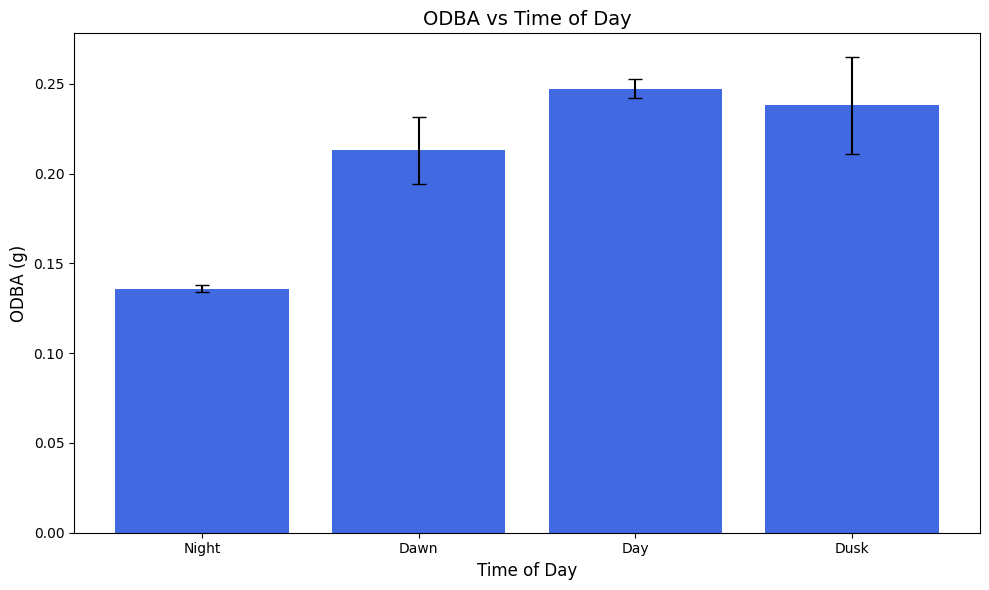

In [13]:
# Plot: ODBA vs Time of Day
plt.figure(figsize=(10, 6))
plt.bar(odba_time_of_day.index, odba_time_of_day['mean'], yerr=odba_time_of_day['sem'], capsize=5, color='royalblue')
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('ODBA (g)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('ODBA vs Time of Day', fontsize=14)
plt.tight_layout()
plt.show()

### ODBA vs Depth

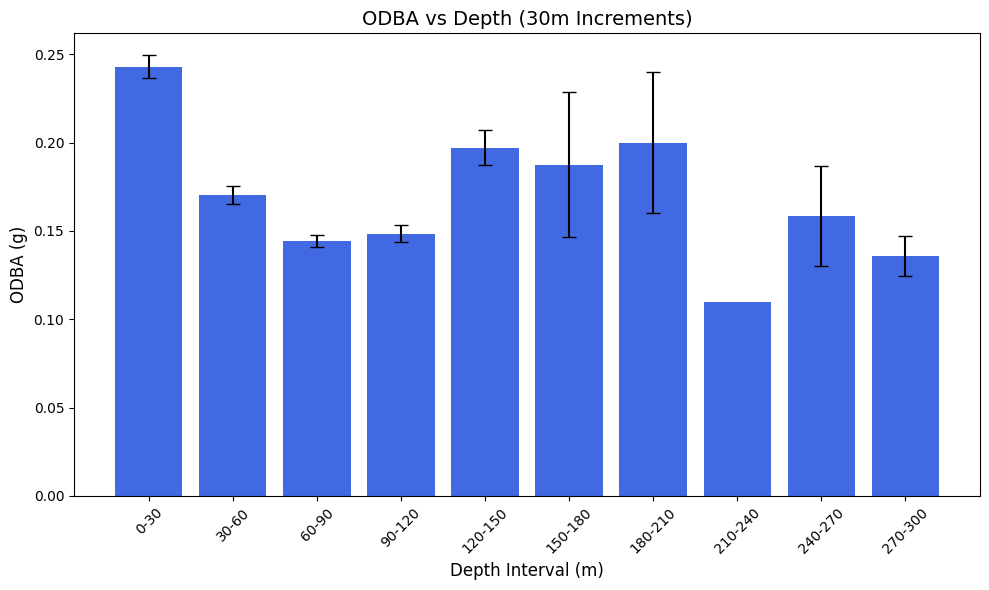

In [14]:
# Plot: ODBA vs Depth
plt.figure(figsize=(10, 6))
plt.bar(odba_depth.index.astype(str), odba_depth['mean'], yerr=odba_depth['sem'], capsize=5, color='royalblue')
plt.xlabel('Depth Interval (m)', fontsize=12)
plt.ylabel('ODBA (g)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title('ODBA vs Depth (30m Increments)', fontsize=14)
plt.tight_layout()
plt.show()

### ODBA vs Number of Boats

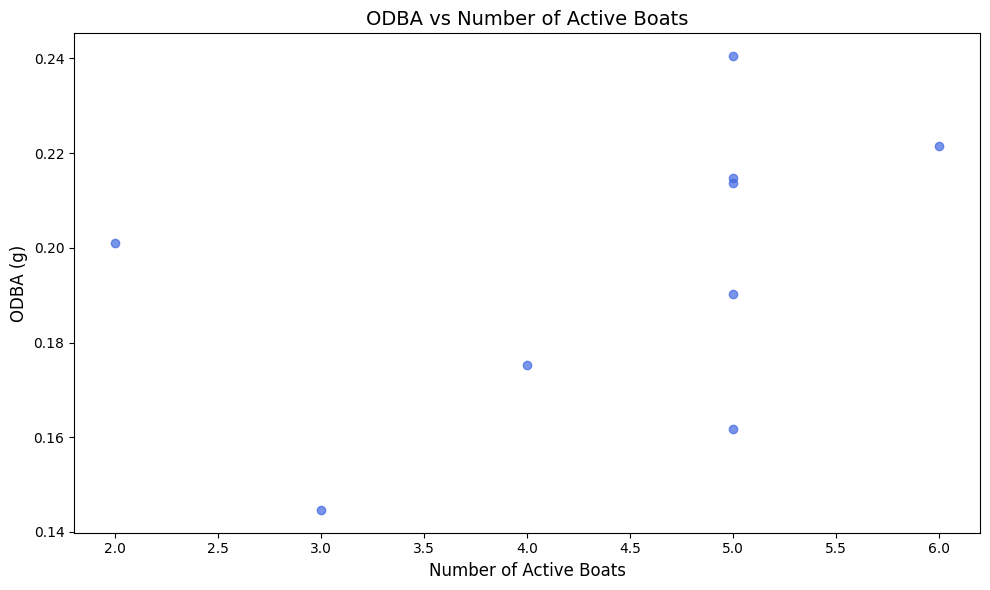

In [15]:
# Plot: ODBA vs Number of Boats
plt.figure(figsize=(10, 6))
plt.scatter(boats_data['# of Active Boats'], boats_data['ODBA (g)'], color='royalblue', alpha=0.7)
plt.xlabel('Number of Active Boats', fontsize=12)
plt.ylabel('ODBA (g)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('ODBA vs Number of Active Boats', fontsize=14)
plt.tight_layout()
plt.show()

### ODBA vs Time with Time of Day Bands

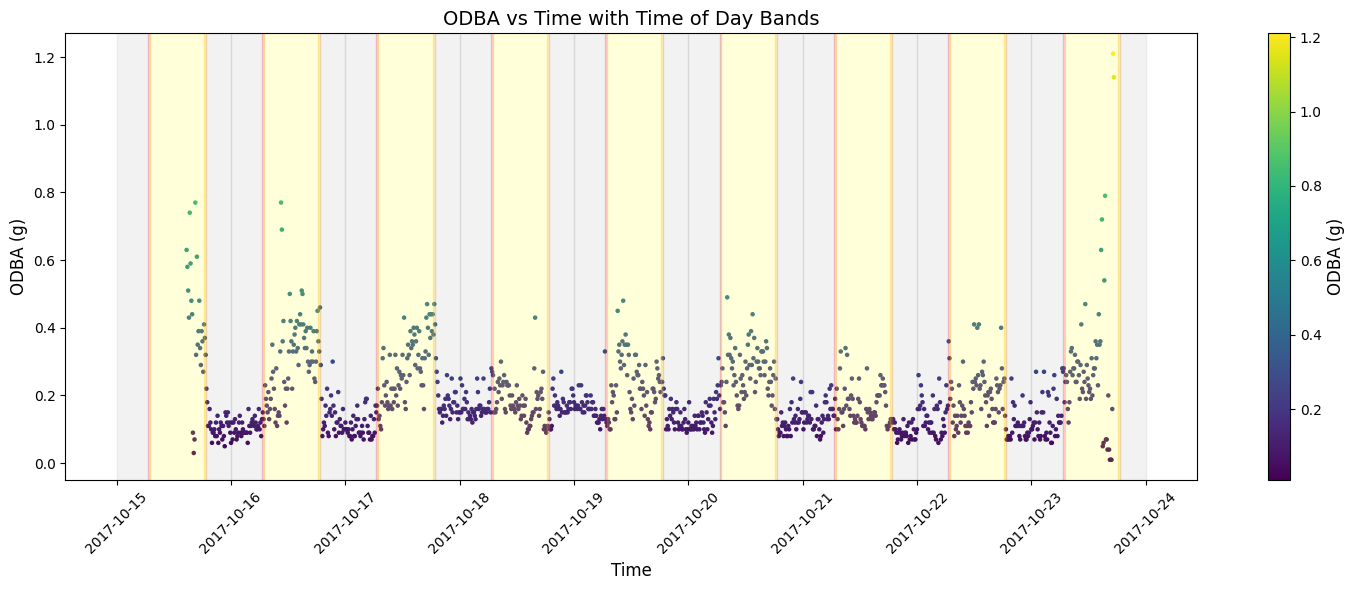

In [16]:
# Plot: ODBA vs Time with Time of Day Bands
import matplotlib.cm as cm

# Define colormap for ODBA values
cmap = plt.get_cmap('viridis')

# Define normalization for colormap
norm = plt.Normalize(odba_data['ODBA (g)'].min(), odba_data['ODBA (g)'].max())

# Initialize the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Plot ODBA over time
scatter = ax.scatter(odba_data['Time Stamp'], odba_data['ODBA (g)'], c=odba_data['ODBA (g)'], cmap=cmap, norm=norm, s=5)

# Plot time of day bands
for date, cycles in sun_cycles.items():
    # Extract times
    night_start = datetime.combine(date, datetime.min.time())
    dawn_start = cycles['nautical_twilight_start']
    sunrise = cycles['sunrise']
    sunset = cycles['sunset']
    dusk_end = cycles['nautical_twilight_end']
    night_end = datetime.combine(date, datetime.max.time())
    
    # Plot bands
    ax.axvspan(night_start, dawn_start, color='black', alpha=0.05)
    ax.axvspan(dawn_start, sunrise, color='red', alpha=0.15)
    ax.axvspan(sunrise, sunset, color='yellow', alpha=0.15)
    ax.axvspan(sunset, dusk_end, color='orange', alpha=0.2)
    ax.axvspan(dusk_end, night_end, color='black', alpha=0.05)

# Formatting x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.xlabel('Time', fontsize=12)
plt.ylabel('ODBA (g)', fontsize=12)
plt.title('ODBA vs Time with Time of Day Bands', fontsize=14)
plt.tight_layout()

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('ODBA (g)', fontsize=12)

plt.show()